## Survey data of COVID case fatality rate by state

- Raw data sourced from COVID Tracking Project

### Terms of use

- The COVID Tracking Project at The Atlantic’s data and website content is published under a Creative Commons CC BY 4.0 license, which requires users to attribute the source and license type (CC BY 4.0) when sharing our data or website content.

### Citation

- [the COVID Tracking Project](https://www.covidtrackingproject.com), Creative Commons CC BY 4.0 license

In [26]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

In [28]:
covidtracking.columns

Index(['date', 'state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNe

In [29]:
df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease']]
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13045 entries, 0 to 13044
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              13045 non-null  int64 
 1   state             13045 non-null  object
 2   fips              13045 non-null  int64 
 3   positiveIncrease  13045 non-null  int64 
 4   deathIncrease     13045 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 509.7+ KB


In [30]:
df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-03-10']

In [31]:
df_state.state.unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [32]:
ls

covid-outbreak-vs-uptick.ipynb  img/  LICENSE  README.md


In [33]:
st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') # Load in state population counts and merge with ctp data
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
df_state.isna().sum() # No missing values!

date                0
state               0
fips                0
positiveIncrease    0
deathIncrease       0
State               0
Code                0
Population          0
CVD_group           0
dtype: int64

In [34]:
grouped_cvd = df_state.groupby(['CVD_group', 'date']).sum().reset_index()
grouped_cvd = grouped_cvd.drop('Population', axis=1)

In [35]:
# Create state groupings and then calculate simple moving averages of the case counts and death counts
group_population = st_population.groupby('CVD_group').sum().reset_index()
grouped_cvd = grouped_cvd.merge(group_population, on='CVD_group')
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

In [36]:
case_SMA = []
death_SMA = []
for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    case_SMA.append(group_df.iloc[:,3].rolling(window=14).mean())
    death_SMA.append(group_df.iloc[:,4].rolling(window=14).mean())
grouped_cvd['case_SMA']= pd.concat(case_SMA)
grouped_cvd['death_SMA']= pd.concat(death_SMA)

In [37]:
grouped_cvd.tail(1)

,CVD_group,date,fips,positiveIncrease,deathIncrease,Population,case_SMA,death_SMA
907,Fall outbreak,2020-10-22,169,6420,50,8537933,5328.071429,39.285714


In [38]:
# Create a table to analyze the summer outbreak
# How many extra deaths occurred as a result of the summer outbreak? 
# Calc = sum of actual deaths from COVID in the summer outbreak group
# minus the expected deaths from COVID based on 'no outbreak' death rate
summer_outbreak_table = (grouped_cvd[(grouped_cvd['CVD_group'].isin(['No outbreak', 'Summer outbreak']) 
                                      & (grouped_cvd['date'] >= '2020-07-05') 
                                      & (grouped_cvd['date'] <= '2020-10-01'))])
summer_group_actual_deaths = summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['deathIncrease'].sum()
summer_group_expected_deaths = (summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['deathIncrease'].sum() 
                                / summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['Population'].iloc[0] 
                                * summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['Population'].iloc[0])
summer_group_excess_deaths = summer_group_actual_deaths  - summer_group_expected_deaths
summer_group_excess_deaths

23312.174591343028

In [39]:
summer_outbreak_table

,CVD_group,date,fips,positiveIncrease,deathIncrease,Population,case_SMA,death_SMA
117,No outbreak,2020-07-05,850,18419,66,158484937,17368.857143,202.500000
118,No outbreak,2020-07-06,850,17844,79,158484937,17820.642857,201.785714
119,No outbreak,2020-07-07,850,18113,360,158484937,18201.642857,207.571429
120,No outbreak,2020-07-08,850,26454,323,158484937,18814.857143,212.928571
121,No outbreak,2020-07-09,850,23811,337,158484937,19392.428571,219.214286
...,...,...,...,...,...,...,...,...
655,Summer outbreak,2020-09-27,182,5968,96,79574777,11968.785714,307.214286
656,Summer outbreak,2020-09-28,182,7439,44,79574777,11913.000000,303.000000
657,Summer outbreak,2020-09-29,182,10678,285,79574777,11824.428571,293.357143
658,Summer outbreak,2020-09-30,182,10919,365,79574777,11684.857143,290.500000


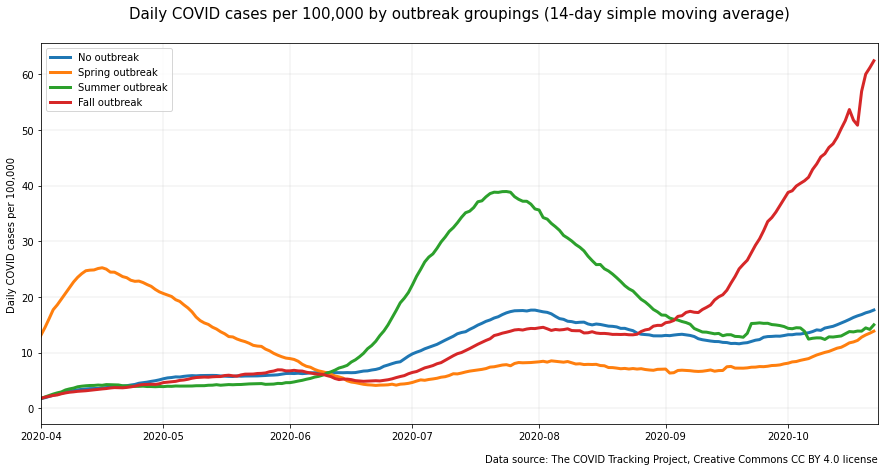

In [40]:
# Cases per 100,000 by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    ax.plot(group_df['date'], group_df['case_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases per 100,000')
ax.legend()

plt.savefig('img/COVID-cases-by-outbreak-groupings.png')

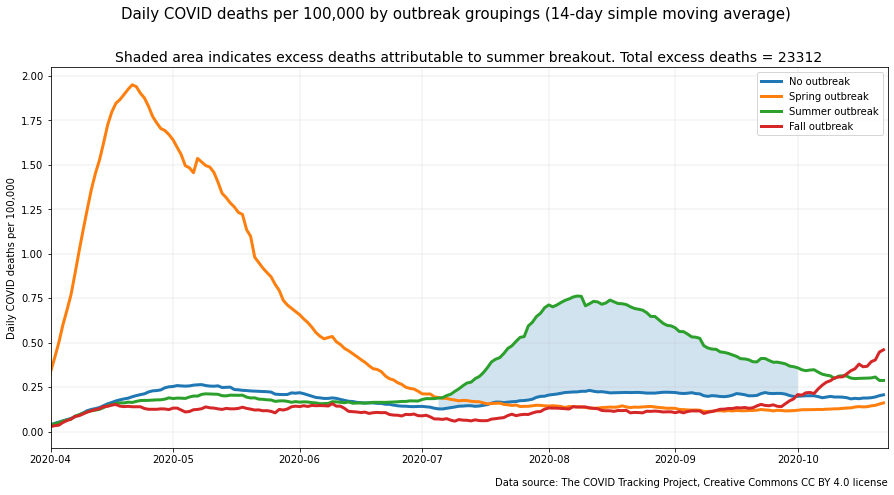

In [41]:
# Deaths per 100,000 by group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID deaths per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1)
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    ax.plot(group_df['date'], group_df['death_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3) 

ax.set_title(f'Shaded area indicates excess deaths attributable to summer breakout. Total excess deaths = {summer_group_excess_deaths:.0f}', size=14)
ax.set_ylabel('Daily COVID deaths per 100,000')
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.fill_between(pd.date_range(datetime.date(2020, 7, 5),datetime.date(2020, 10, 1),freq='d'),
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['death_SMA'] / 
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['Population'].iloc[0] * 100000,
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['death_SMA'] / 
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['Population'].iloc[0] * 100000,
                alpha = 0.2 )
ax.legend()
plt.savefig('img/COVID-deaths-by-outbreak-groupings.png')

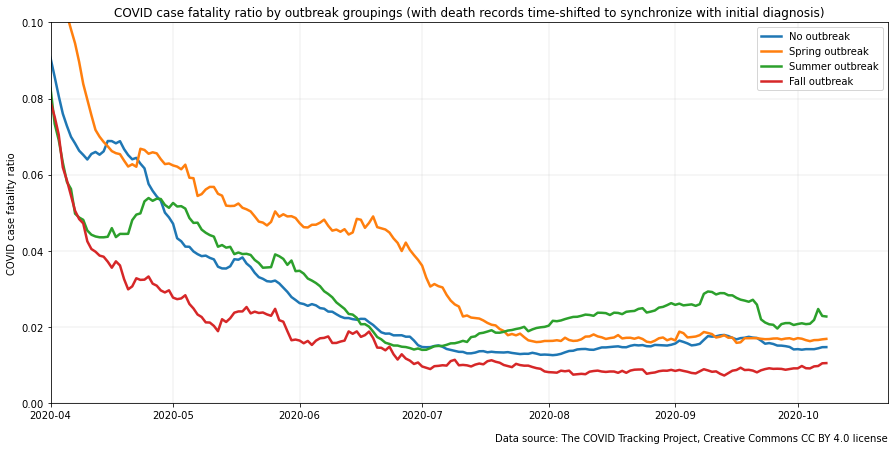

In [42]:
# Case fatality ratio by outbreak group over time
fig, ax = plt.subplots(figsize = (15,7))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    temp_group_df = group_df[['date', 'death_SMA']]
    temp_group_df['date'] = temp_group_df['date'] - timedelta(days=14) # shifting death records by 14 days to sync with cases
    group_df = group_df.merge(temp_group_df, on='date')
    ax.plot(group_df['date'], group_df['death_SMA_y'] / group_df['case_SMA'], label = chart_group, lw=2.5)

ax.set_ylabel('COVID case fatality ratio')
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.1)
ax.set_title(f'COVID case fatality ratio by outbreak groupings (with death records time-shifted to synchronize with initial diagnosis)')
ax.legend()
plt.savefig('img/COVID-case-fatality-by-outbreak-groupings.png')

### State-level case and death rate animations by week

In [43]:
# Prepare data table for the animation of deaths per 100,000 and cases per 100,000 by state by week (but reported as a daily statistic)
# Start by grouping by state and week. (Summing over the week avoids the need to apply a moving average and it speeds up the animation.)
# Smooth the death figures over two weeks to match the smoothing from the previous time series.
# Calculate daily deaths per 100000.

In [44]:
# ADD CODE. Close out on a complete week (ending Saturday) when reporting weekly statistics.
# TBD

df_state['week']=df_state['date'].dt.week
df_state_by_week = df_state.groupby(['week','state','Population']).agg(
                                    deaths = ('deathIncrease', 'sum'),
                                    cases = ('positiveIncrease','sum'),
                                    Date = ('date', 'max')).reset_index()

In [45]:
death_SMA = []
for chart_state in df_state_by_week['state'].unique():
    state = df_state_by_week[df_state_by_week['state']== chart_state]
    death_SMA.append(state.iloc[:,3].rolling(window=2).mean())
df_state_by_week['death_SMA']= pd.concat(death_SMA)

In [46]:
df_state_by_week['deaths_per_100000'] = df_state_by_week['death_SMA'] / df_state_by_week['Population'] * 100000 / 7
df_state_by_week['cases_per_100000'] = df_state_by_week['cases'] / df_state_by_week['Population'] * 100000 / 7

In [47]:
df_state_by_week['timestamp'] = df_state_by_week['Date'].apply(lambda x: x.date()).apply(str) # convert timestamp to a string 
df_state_by_week = df_state_by_week.sort_values('timestamp', ascending=True)

In [51]:
fig = px.choropleth(df_state_by_week,                           # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="cases_per_100000",                 # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",            # date column
                     scope="usa",
                     color_continuous_scale = 'Viridis_r',  
                     range_color=[0,300/7],                  # select range of dataset
                     labels={'cases_per_100000':'Cases per 100,000'},
                     title='Daily COVID cases per 100,000 residents'     
                     )                 
fig.write_html("img/case-rate-map.html", auto_open=True)                      

In [49]:
fig = px.choropleth(df_state_by_week,                           # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="deaths_per_100000",                 # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",            # date column
                     scope="usa",
                     color_continuous_scale = 'bluered',  
                     range_color=[0,5.5/7],                  # select range of dataset
                     labels={'deaths_per_100000':'Deaths per 100,000'},
                     title='Daily COVID deaths per 100,000 residents'     
                     )        
fig.write_html("img/death-rate-map.html", auto_open=True)                      

In [62]:
case_SMA = []
death_SMA = []
for chart_state in df_state['state'].unique():
    state = df_state[df_state['state']== chart_state]
    case_SMA.append(state.iloc[:,3].rolling(window=14).mean())
    death_SMA.append(state.iloc[:,4].rolling(window=14).mean())
df_state['case_SMA']= pd.concat(case_SMA)
df_state['death_SMA']= pd.concat(death_SMA)
df_state['case_SMA'] = df_state['case_SMA'] / df_state['Population'] * 100000
df_state['death_SMA'] = df_state['death_SMA'] / df_state['Population'] * 100000
df_state.dropna(inplace=True)

In [96]:
df_state['timestamp'] = df_state['date'].apply(lambda x: x.date()).apply(str) # convert timestamp to a string 
df_state = df_state.sort_values('timestamp', ascending=True)

fig = px.choropleth(df_state,                           # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="death_SMA",                 # feature column
#                      hover_name="state",                # hover name
                     animation_frame="timestamp",            # date column
                     scope="usa",
                     color_continuous_scale = 'Viridis',  
                     range_color=[0,1]                  # select range of dataset
                     )        
fig.show()          
fig.write_html("img/death-rate-map.html", auto_open=True)                      

In [47]:
first, last = (47,48)

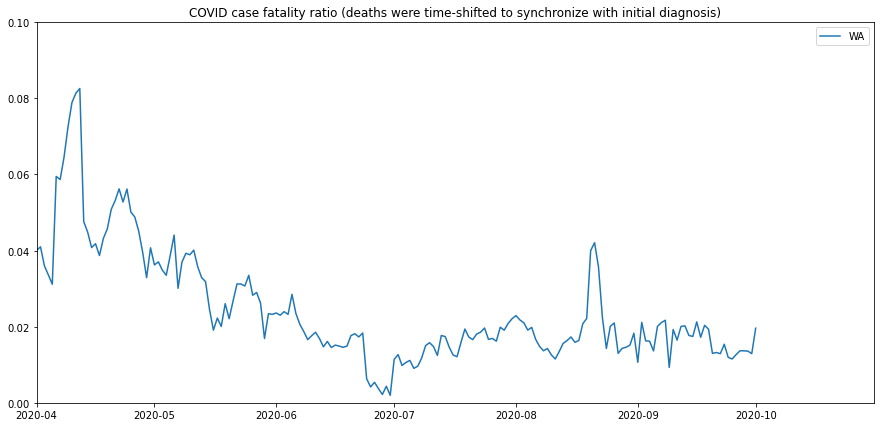

In [48]:
# Case fatality ratio by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
    state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=7).mean()
    state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=7).mean()
    temp_state_df = state_df[['date', 'death_SMA']]
    temp_state_df['date'] = temp_state_df['date'] - timedelta(days=14)
    state_df = state_df.merge(temp_state_df, on='date')
    ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 31)])
    ax.set_ylim(0, 0.1)
    ax.set_title(f'COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
    ax.legend()

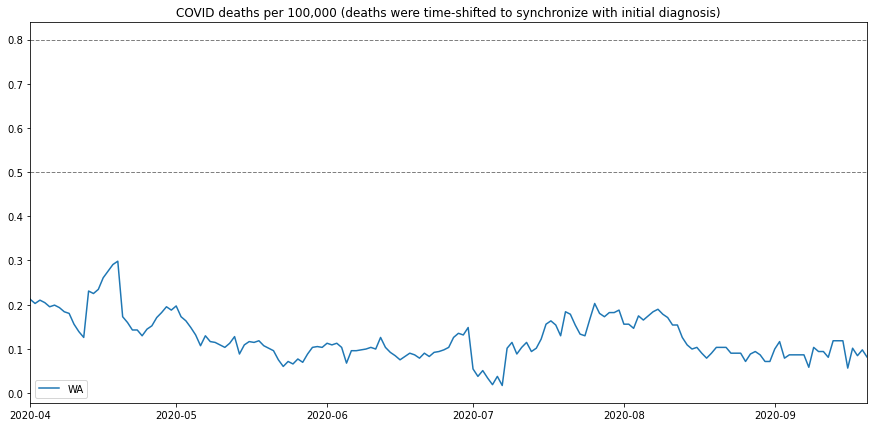

In [49]:
# Deaths per 100,000 by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
    state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=7).mean()
    temp_state_df = state_df[['date', 'death_SMA']]
    temp_state_df['date'] = temp_state_df['date'] - timedelta(days=7)
    state_df = state_df.merge(temp_state_df, on='date')
    ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['Population'] * 100000, label = chart_state)
    ax.axhline(y=0.8, ls= '--', lw=1, color = 'gray')
    ax.axhline(y=0.5, ls= '--', lw=1, color = 'gray')
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 9, 20)])
    ax.set_title(f'COVID deaths per 100,000 (deaths were time-shifted to synchronize with initial diagnosis)')
    ax.legend()

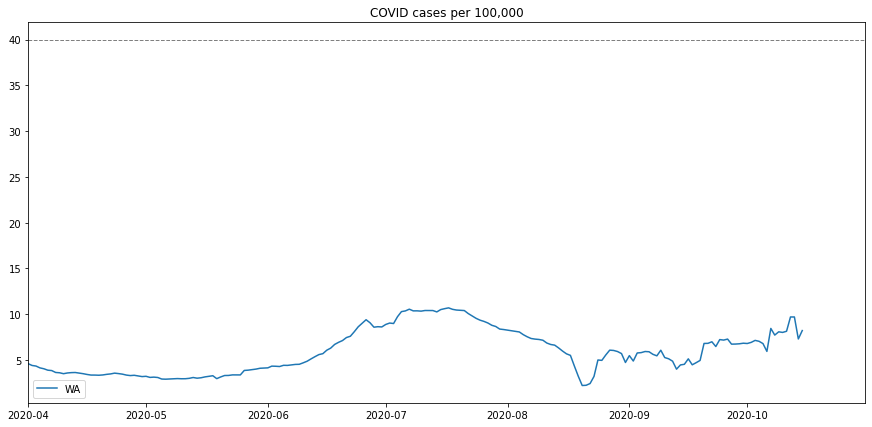

In [50]:
# Cases per 100,000 by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
    state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=7).mean()
    ax.plot(state_df['date'], state_df['case_SMA'] / state_df['Population'] * 100000, label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 31)])
    ax.set_title(f'COVID cases per 100,000')
    ax.axhline(y=40, ls= '--', lw=1, color = 'gray')
    ax.legend()

In [51]:
chart_state = 'WA'
state_df = df_state[df_state['state']== chart_state]
state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=14).mean()
state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=14).mean()
temp_state_df = state_df[['date', 'death_SMA']]
temp_state_df['date'] = temp_state_df['date'] - timedelta(days=21)
state_df = state_df.merge(temp_state_df, on='date')

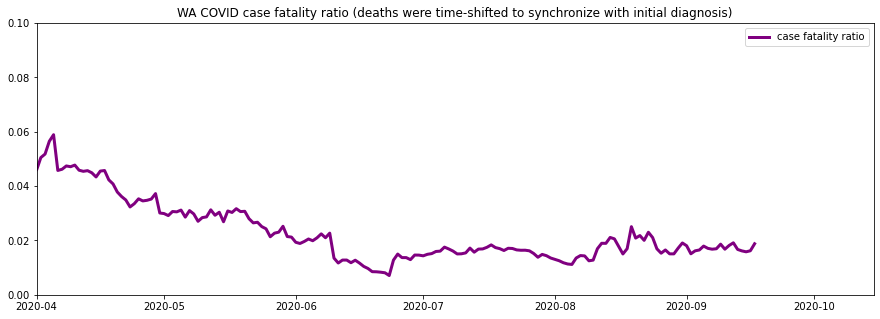

In [52]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = 'case fatality ratio', color = 'purple', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_ylim(0, 0.1)
ax.set_title(f'{chart_state} COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
ax.legend()

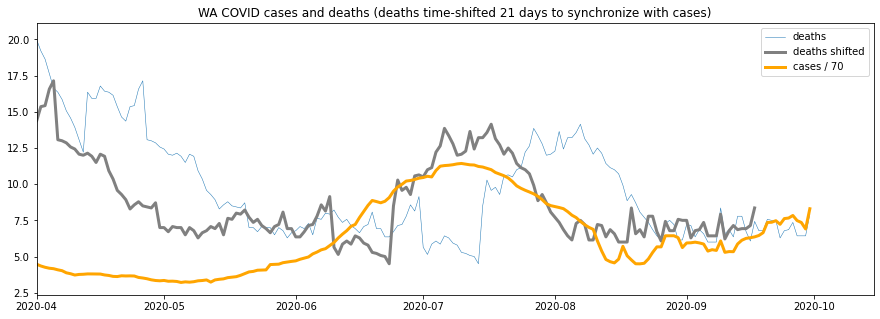

In [53]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_x'], label = 'deaths', lw= .5)
ax.plot(state_df['date'], state_df['death_SMA_y'], label = 'deaths shifted', color = 'gray', lw=3)
ax.plot(state_df['date'], state_df['case_SMA'] / 70, label = 'cases / 70', color = 'orange', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_title(f'{chart_state} COVID cases and deaths (deaths time-shifted 21 days to synchronize with cases)')
ax.legend()